In [1]:
%load_ext autoreload
%autoreload 2

import logging
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import defi.dao_cross.supply_demand as ddcrsede
import defi.dao_cross.order as ddacrord

In [2]:
try:
    import pulp
except ImportError:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install pulp)"
    import pulp
import defi.dao_cross.optimize as ddacropt

     |████████████████████████████████| 14.3 MB 11.3 MB/s eta 0:00:01


In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-5319cf82-0d33-40b4-8d52-943cdfbe3d02.json'
DEBUG Effective logging level=10
DEBUG Shut up 28 modules: matplotlib.colorbar, matplotlib.text, matplotlib.category, matplotlib.textpath, matplotlib.ticker, matplotlib._layoutgrid, matplotlib.axes, matplotlib, matplotlib.style.core, matplotlib.image, matplotlib.lines, matplotlib.texmanager, matplotlib.dviread, matplotlib.artist, matplotlib.mathtext, matplotlib.gridspec, matplotlib._afm, matplotlib.backend_bases, asyncio, matplotlib.axes._axes, matplotlib.axes._base, matplotlib.figure, matplotlib.font_manager, matplotlib._constrained_layout, matplotlib.dates, matplotlib.axis, matplotlib.pyplot, matplotlib.style
DEBUG > (cd . && cd "$(git rev-parse --show-toplevel)/.." && (git rev-parse --is-inside-work-tree | grep -q true)) 2>&1
DEBUG > (git rev-parse --show-toplevel) 2>&1
-----------------------------------------------------------

# Pathological cases

## Get orders and set prices.

In [4]:
type_ = "supply"
supply_quantities = [1, 1, 1, 1]
supply_limit_prices = [1.5, 2, 3, 3.5]
#
supply_orders1 = ddcrsede.get_curve_orders(
    type_, supply_quantities, supply_limit_prices
)
ddacrord.convert_orders_to_dataframe(supply_orders1)

timestamp action  quantity base_token  limit_price quote_token  deposit_address
0 2023-04-27 11:15:49.248710+00:00   sell         1        BTC          1.5         ETH                9
1 2023-04-27 11:15:49.248792+00:00   sell         1        BTC          2.0         ETH                4
2 2023-04-27 11:15:49.248804+00:00   sell         1        BTC          3.0         ETH               10
3 2023-04-27 11:15:49.248811+00:00   sell         1        BTC          3.5         ETH                8

In [5]:
type_ = "demand"
demand_quantities = [1, 1, 1, 1]
demand_limit_prices = [3.5, 2.5, 2, 1.5]
#
demand_orders1 = ddcrsede.get_curve_orders(
    type_, demand_quantities, demand_limit_prices
)
ddacrord.convert_orders_to_dataframe(demand_orders1)

timestamp action  quantity base_token  limit_price quote_token  deposit_address
0 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9
1 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8
2 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1
3 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1

In [6]:
prices = {"BTC": 1, "ETH": 2}

## Multiple intersection points at quantity Q'

In [7]:
type_ = "supply"
supply_curve1 = ddcrsede.get_curve_dots(supply_orders1, type_)
supply_curve1

[(0, 1.5),
 (1.0, 1.5),
 (1.0, 2.0),
 (2.0, 2.0),
 (2.0, 3.0),
 (3.0, 3.0),
 (3.0, 3.5),
 (4.0, 3.5),
 (4.0, 4.375)]

In [8]:
type_ = "demand"
demand_curve1 = ddcrsede.get_curve_dots(demand_orders1, type_)
demand_curve1

[(0, 3.5),
 (1.0, 3.5),
 (1.0, 2.5),
 (2.0, 2.5),
 (2.0, 2.0),
 (3.0, 2.0),
 (3.0, 1.5),
 (4.0, 1.5),
 (4.0, 0)]

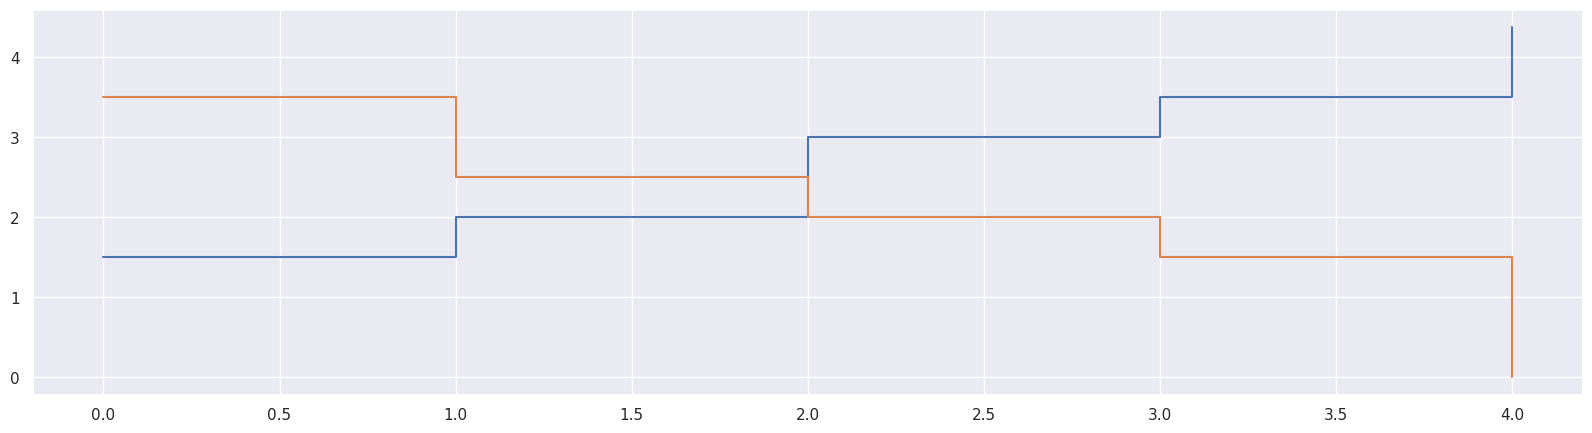

In [9]:
plt.plot(*zip(*supply_curve1))
plt.plot(*zip(*demand_curve1))
plt.show()

In [10]:
all_orders1 = supply_orders1 + demand_orders1
daocross_results1 = ddacropt.run_daocross_solver(all_orders1, prices)
display(daocross_results1)

DEBUG orders=[timestamp=2023-04-27 11:15:49.248710+00:00 action=sell quantity=1.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.248792+00:00 action=sell quantity=1.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-27 11:15:49.248804+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-27 11:15:49.248811+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:15:49.248710+00:00   sell         1        BTC          1.5         ETH                9        1.0         2.0              2.0
1 2023-04-27 11:15:49.248792+00:00   sell         1        BTC          2.0         ETH                4        1.0         2.0              2.0
2 2023-04-27 11:15:49.248804+00:00   sell         1        BTC          3.0         ETH               10        0.0         0.0              NaN
3 2023-04-27 11:15:49.248811+00:00   sell         1        BTC          3.5         ETH                8        0.0         0.0              NaN
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9        1.0         2.0              2.0
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8        1.0         2.0              2.0
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1        0.0         0.0              NaN
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1        0.0         0.0              NaN

In [12]:
daoswap_results1 = ddacropt.run_daoswap_solver(all_orders1)
display(daoswap_results1)

DEBUG orders=[timestamp=2023-04-27 11:15:49.248710+00:00 action=sell quantity=1.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.248792+00:00 action=sell quantity=1.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-27 11:15:49.248804+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-27 11:15:49.248811+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:15:49.248710+00:00   sell         1        BTC          1.5         ETH                9       1.00       1.500              1.5
1 2023-04-27 11:15:49.248792+00:00   sell         1        BTC          2.0         ETH                4       1.00       2.000              2.0
2 2023-04-27 11:15:49.248804+00:00   sell         1        BTC          3.0         ETH               10       1.00       3.000              3.0
3 2023-04-27 11:15:49.248811+00:00   sell         1        BTC          3.5         ETH                8       0.75       2.625              3.5
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9       1.00       3.500              3.5
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8       1.00       2.500              2.5
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1       1.00       2.000              2.0
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1       0.75       1.125              1.5

## Multiple intersection points at price P'

In [13]:
quantity_const = 1.0
type_ = "supply"
supply_orders2 = ddcrsede.get_curve_orders(
    type_,
    supply_quantities,
    supply_limit_prices,
    quantity_const=quantity_const,
)
ddacrord.convert_orders_to_dataframe(supply_orders2)

timestamp action  quantity base_token  limit_price quote_token  deposit_address
0 2023-04-27 11:16:13.337736+00:00   sell         2        BTC          1.5         ETH                7
1 2023-04-27 11:16:13.337790+00:00   sell         2        BTC          2.0         ETH                2
2 2023-04-27 11:16:13.337800+00:00   sell         2        BTC          3.0         ETH                2
3 2023-04-27 11:16:13.337808+00:00   sell         2        BTC          3.5         ETH               10

In [14]:
type_ = "supply"
supply_curve2 = ddcrsede.get_curve_dots(supply_orders2, type_)
supply_curve2

[(0, 1.5),
 (2.0, 1.5),
 (2.0, 2.0),
 (4.0, 2.0),
 (4.0, 3.0),
 (6.0, 3.0),
 (6.0, 3.5),
 (8.0, 3.5),
 (8.0, 4.375)]

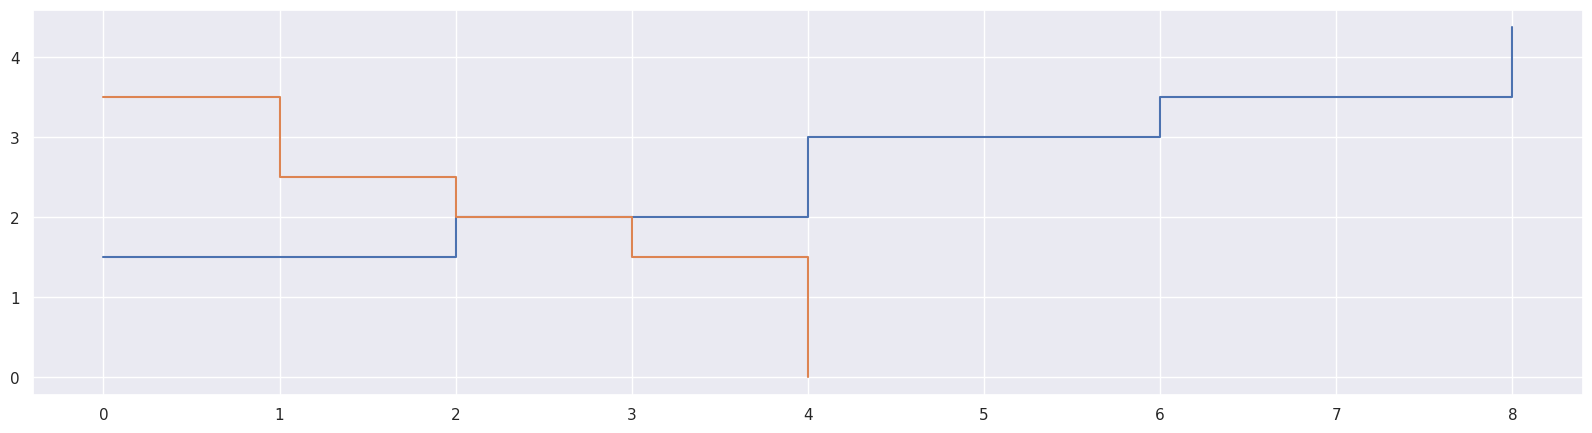

In [15]:
plt.plot(*zip(*supply_curve2))
plt.plot(*zip(*demand_curve1))
plt.show()

In [16]:
all_orders2 = supply_orders2 + demand_orders1
daocross_results2 = ddacropt.run_daocross_solver(all_orders2, prices)
display(daocross_results2)

DEBUG orders=[timestamp=2023-04-27 11:16:13.337736+00:00 action=sell quantity=2.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=7 wallet_address=7, timestamp=2023-04-27 11:16:13.337790+00:00 action=sell quantity=2.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-04-27 11:16:13.337800+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-04-27 11:16:13.337808+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:16:13.337736+00:00   sell         2        BTC          1.5         ETH                7        1.0         2.0              2.0
1 2023-04-27 11:16:13.337790+00:00   sell         2        BTC          2.0         ETH                2        2.0         4.0              2.0
2 2023-04-27 11:16:13.337800+00:00   sell         2        BTC          3.0         ETH                2        0.0         0.0              NaN
3 2023-04-27 11:16:13.337808+00:00   sell         2        BTC          3.5         ETH               10        0.0         0.0              NaN
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9        1.0         2.0              2.0
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8        1.0         2.0              2.0
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1        1.0         2.0              2.0
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1        0.0         0.0              NaN

In [17]:
daoswap_results2 = ddacropt.run_daoswap_solver(all_orders2)
display(daoswap_results2)

DEBUG orders=[timestamp=2023-04-27 11:16:13.337736+00:00 action=sell quantity=2.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=7 wallet_address=7, timestamp=2023-04-27 11:16:13.337790+00:00 action=sell quantity=2.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-04-27 11:16:13.337800+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-04-27 11:16:13.337808+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:16:13.337736+00:00   sell         2        BTC          1.5         ETH                7   0.333333         0.5              1.5
1 2023-04-27 11:16:13.337790+00:00   sell         2        BTC          2.0         ETH                2   2.000000         4.0              2.0
2 2023-04-27 11:16:13.337800+00:00   sell         2        BTC          3.0         ETH                2   1.666667         5.0              3.0
3 2023-04-27 11:16:13.337808+00:00   sell         2        BTC          3.5         ETH               10   0.000000        -0.0              NaN
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9   1.000000         3.5              3.5
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8   1.000000         2.5              2.5
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1   1.000000         2.0              2.0
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1   1.000000         1.5              1.5

## No intersection

In [18]:
limit_price_const = 5.0
supply_orders3 = ddcrsede.get_curve_orders(
    type_,
    supply_quantities,
    supply_limit_prices,
    limit_price_const=limit_price_const,
)
ddacrord.convert_orders_to_dataframe(supply_orders3)

timestamp action  quantity base_token  limit_price quote_token  deposit_address
0 2023-04-27 11:16:44.867564+00:00   sell         1        BTC          6.5         ETH                4
1 2023-04-27 11:16:44.867617+00:00   sell         1        BTC          7.0         ETH                3
2 2023-04-27 11:16:44.867627+00:00   sell         1        BTC          8.0         ETH                5
3 2023-04-27 11:16:44.867634+00:00   sell         1        BTC          8.5         ETH                8

In [19]:
type_ = "supply"
supply_curve3 = ddcrsede.get_curve_dots(supply_orders3, type_)
supply_curve3

[(0, 6.5),
 (1.0, 6.5),
 (1.0, 7.0),
 (2.0, 7.0),
 (2.0, 8.0),
 (3.0, 8.0),
 (3.0, 8.5),
 (4.0, 8.5),
 (4.0, 10.625)]

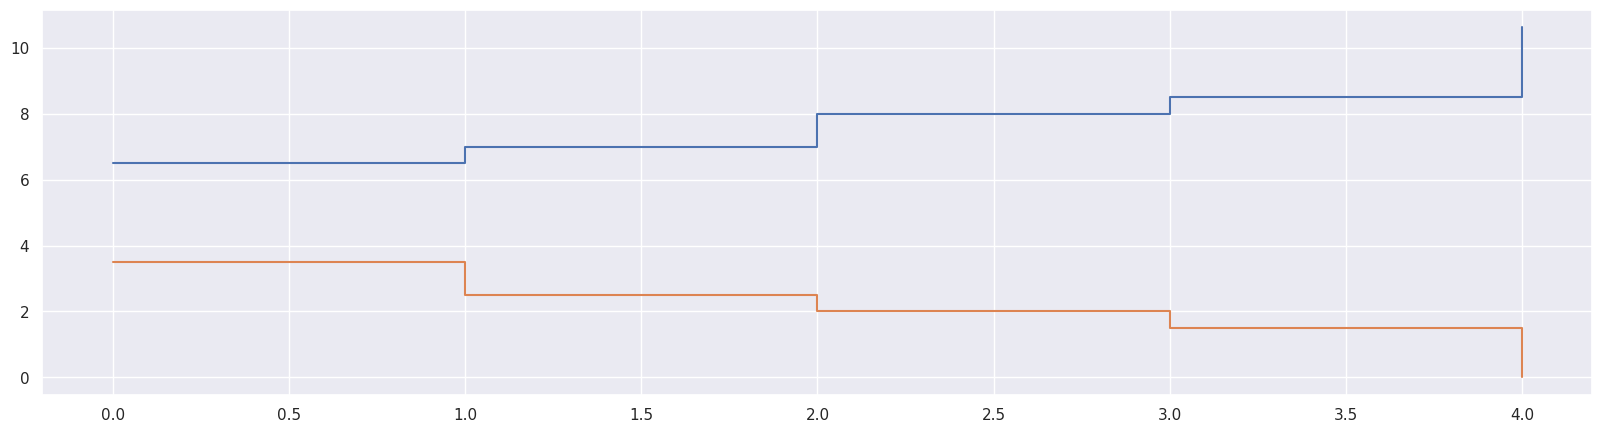

In [20]:
plt.plot(*zip(*supply_curve3))
plt.plot(*zip(*demand_curve1))
plt.show()

In [21]:
all_orders3 = supply_orders3 + demand_orders1
daocross_results3 = ddacropt.run_daocross_solver(all_orders3, prices)
display(daocross_results3)

DEBUG orders=[timestamp=2023-04-27 11:16:44.867564+00:00 action=sell quantity=1.0 base_token=BTC limit_price=6.5 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-27 11:16:44.867617+00:00 action=sell quantity=1.0 base_token=BTC limit_price=7.0 quote_token=ETH deposit_address=3 wallet_address=3, timestamp=2023-04-27 11:16:44.867627+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.0 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-04-27 11:16:44.867634+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BTC 

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:16:44.867564+00:00   sell         1        BTC          6.5         ETH                4        0.0         0.0              NaN
1 2023-04-27 11:16:44.867617+00:00   sell         1        BTC          7.0         ETH                3        0.0         0.0              NaN
2 2023-04-27 11:16:44.867627+00:00   sell         1        BTC          8.0         ETH                5        0.0         0.0              NaN
3 2023-04-27 11:16:44.867634+00:00   sell         1        BTC          8.5         ETH                8        0.0         0.0              NaN
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9        0.0         0.0              NaN
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8        0.0         0.0              NaN
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1        0.0         0.0              NaN
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1        0.0         0.0              NaN

In [22]:
daoswap_results3 = ddacropt.run_daoswap_solver(all_orders3)
display(daoswap_results3)

DEBUG orders=[timestamp=2023-04-27 11:16:44.867564+00:00 action=sell quantity=1.0 base_token=BTC limit_price=6.5 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-27 11:16:44.867617+00:00 action=sell quantity=1.0 base_token=BTC limit_price=7.0 quote_token=ETH deposit_address=3 wallet_address=3, timestamp=2023-04-27 11:16:44.867627+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.0 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-04-27 11:16:44.867634+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295561+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-27 11:15:49.295604+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-27 11:15:49.295614+00:00 action=buy quantity=1.0 base_token=BTC 

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


timestamp action  quantity base_token  limit_price quote_token  deposit_address  q_pi_star  q_tau_star  effective_price
0 2023-04-27 11:16:44.867564+00:00   sell         1        BTC          6.5         ETH                4        0.0        -0.0              NaN
1 2023-04-27 11:16:44.867617+00:00   sell         1        BTC          7.0         ETH                3        0.0        -0.0              NaN
2 2023-04-27 11:16:44.867627+00:00   sell         1        BTC          8.0         ETH                5        0.0        -0.0              NaN
3 2023-04-27 11:16:44.867634+00:00   sell         1        BTC          8.5         ETH                8        0.0        -0.0              NaN
4 2023-04-27 11:15:49.295561+00:00    buy         1        BTC          3.5         ETH                9        0.0         0.0              NaN
5 2023-04-27 11:15:49.295604+00:00    buy         1        BTC          2.5         ETH                8        0.0         0.0              NaN
6 2023-04-27 11:15:49.295614+00:00    buy         1        BTC          2.0         ETH                1        0.0         0.0              NaN
7 2023-04-27 11:15:49.295622+00:00    buy         1        BTC          1.5         ETH                1        0.0         0.0              NaN